# Lab 02 - Faiss

## Import libraries

In [9]:
# Import necessary libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.metrics.pairwise import cosine_similarity
import faiss
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import models, datasets, transforms


# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Load datasets and preprocessing

In [ ]:
# Dataset and preprocessing
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split dataset into training and test sets (e.g., 80% training, 20% test)
train_size = int(0.8 * len(cifar10))
test_size = len(cifar10) - train_size
train_dataset, test_dataset = random_split(cifar10, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Load one batch from both train and test sets
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

# Use only 1000 images for simplicity
train_images = train_images[:1000]
test_images = test_images[:1000]

# Convert images to grayscale for feature extraction
train_grayscale_images = [transforms.Grayscale()(img) for img in train_images]
test_grayscale_images = [transforms.Grayscale()(img) for img in test_images]


Files already downloaded and verified


## Feature extractors initialization

### Scale-Invariant Feature Transform (SIFT)

In [11]:
# Extract features with SIFT
sift = cv2.SIFT_create()
sift_train_features = []

for img in train_grayscale_images:
    img_np = (img.numpy().squeeze() * 255).astype(np.uint8)
    _, desc = sift.detectAndCompute(img_np, None)
    if desc is not None:
        sift_train_features.append(desc.mean(axis=0))
sift_train_features = np.vstack(sift_train_features)

# Similarly for the test set
sift_test_features = []
for img in test_grayscale_images:
    img_np = (img.numpy().squeeze() * 255).astype(np.uint8)
    _, desc = sift.detectAndCompute(img_np, None)
    if desc is not None:
        sift_test_features.append(desc.mean(axis=0))
sift_test_features = np.vstack(sift_test_features)

### Orientated FAST and Robust BRIEF (ORB)

In [12]:
# Extract features with ORB
orb = cv2.ORB_create()
orb_train_features = []

for img in train_grayscale_images:
    img_np = (img.numpy().squeeze() * 255).astype(np.uint8)
    keypoints, descriptors = orb.detectAndCompute(img_np, None)
    if descriptors is not None:
        orb_train_features.append(descriptors.mean(axis=0))
    else:
        orb_train_features.append(np.zeros(32))
orb_train_features = np.asarray(orb_train_features, dtype=np.float32)

# Similarly for the test set
orb_test_features = []
for img in test_grayscale_images:
    img_np = (img.numpy().squeeze() * 255).astype(np.uint8)
    keypoints, descriptors = orb.detectAndCompute(img_np, None)
    if descriptors is not None:
        orb_test_features.append(descriptors.mean(axis=0))
    else:
        orb_test_features.append(np.zeros(32))
orb_test_features = np.asarray(orb_test_features, dtype=np.float32)

### ResNet50 and DenseNet121 model initialization

In [13]:
# Feature extractors
def extract_features_with_model(images, model, input_size=(224, 224)):  
    features = []
    for img in tqdm(images):
        img_resized = transforms.Resize(input_size)(img)
        img_tensor = img_resized.unsqueeze(0)
        with torch.no_grad():
            output = model(img_tensor).squeeze(0).numpy()
            features.append(output)
    return np.vstack(features)

resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet.eval()
densenet = models.densenet121(pretrained=True)
densenet.eval()

resnet_train_features = extract_features_with_model(train_images, resnet)
densenet_train_features = extract_features_with_model(train_images, densenet)

# Similarly for the test set
resnet_test_features = extract_features_with_model(test_images, resnet)
densenet_test_features = extract_features_with_model(test_images, densenet)

100%|██████████| 1000/1000 [01:31<00:00, 10.91it/s]


## Implementation of Faiss library for similarity calculation and image retrieval

In [14]:
def faiss_search(features, metric="cosine", top_k=5):
    # Ensure features are a NumPy array
    features = np.array(features)
    
    if metric == "cosine":
        faiss.normalize_L2(features)  # Normalize for cosine similarity
        index = faiss.IndexFlatIP(features.shape[1])  # Inner product for cosine similarity
    elif metric == "inner_product":
        index = faiss.IndexFlatIP(features.shape[1])
    elif metric == "l2":
        index = faiss.IndexFlatL2(features.shape[1])
    else:
        raise ValueError(f"Unknown metric: {metric}")
    
    index.add(features)
    distances, indices = index.search(features, top_k)  # Search top_k for the first 10 queries
    return distances, indices

## Running the Experiment


Feature extractor: SIFT
Querying with random image no: 897
Querying with random image no: 0
Querying with random image no: 966


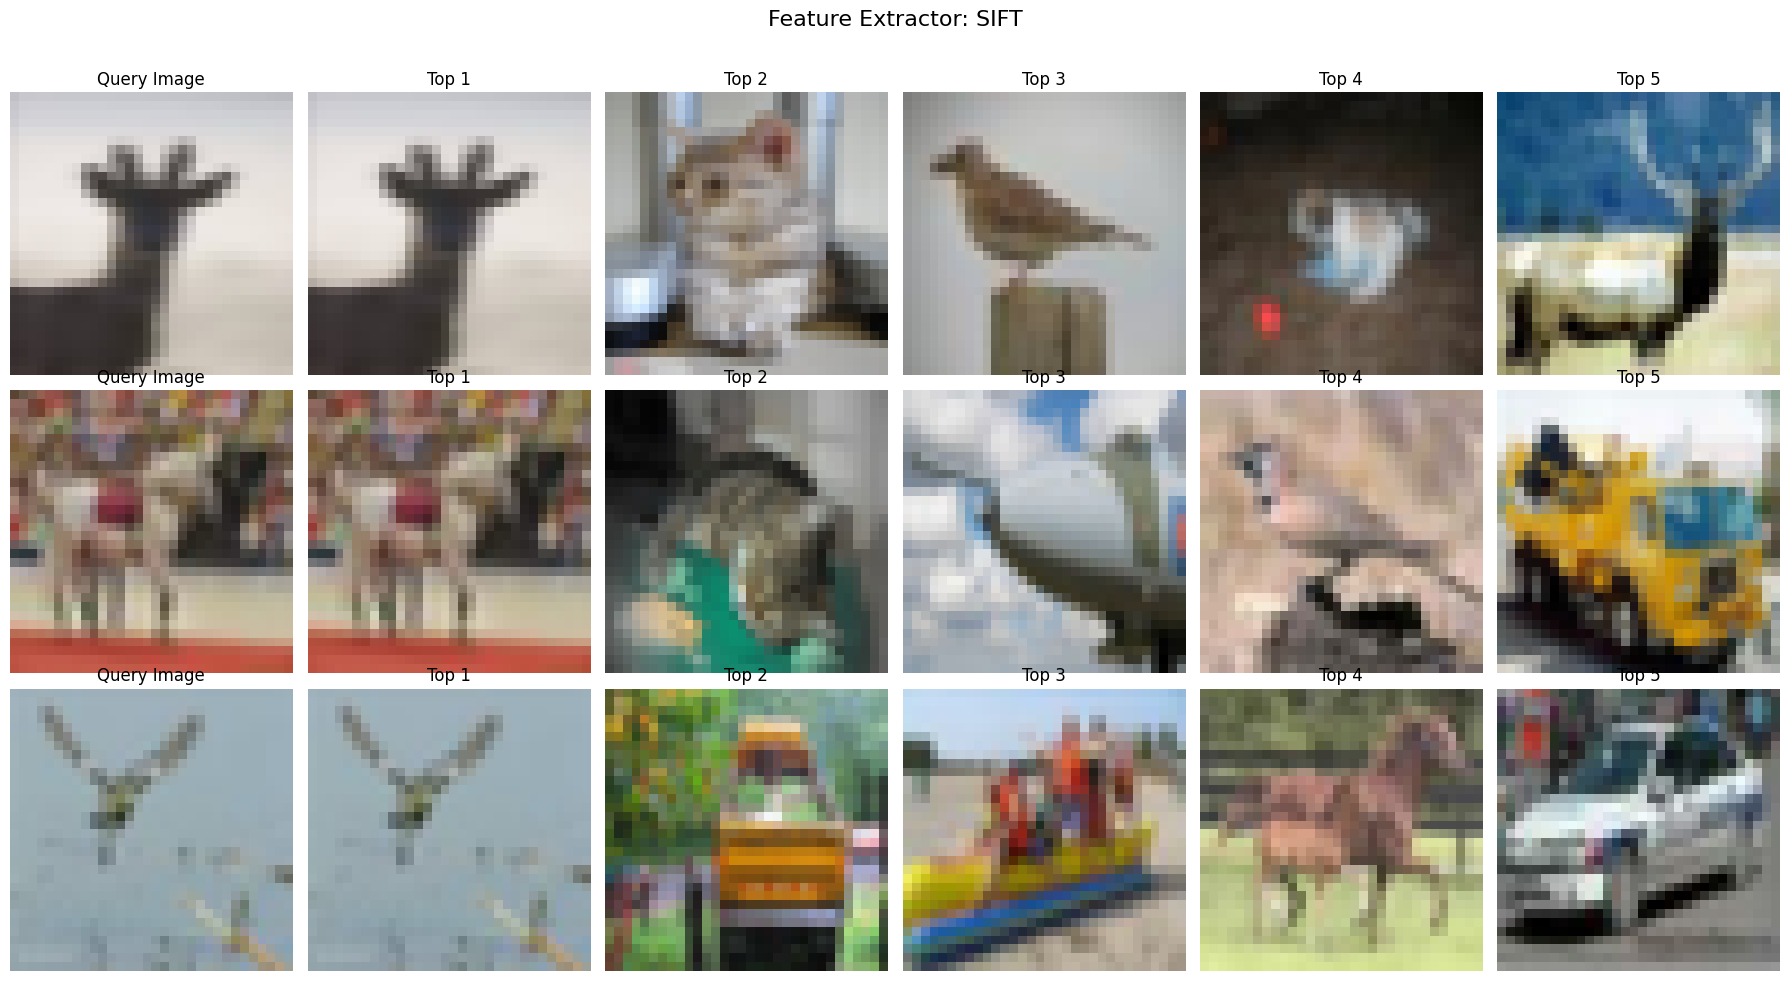


Feature extractor: ORB
Querying with random image no: 158
Querying with random image no: 962
Querying with random image no: 171


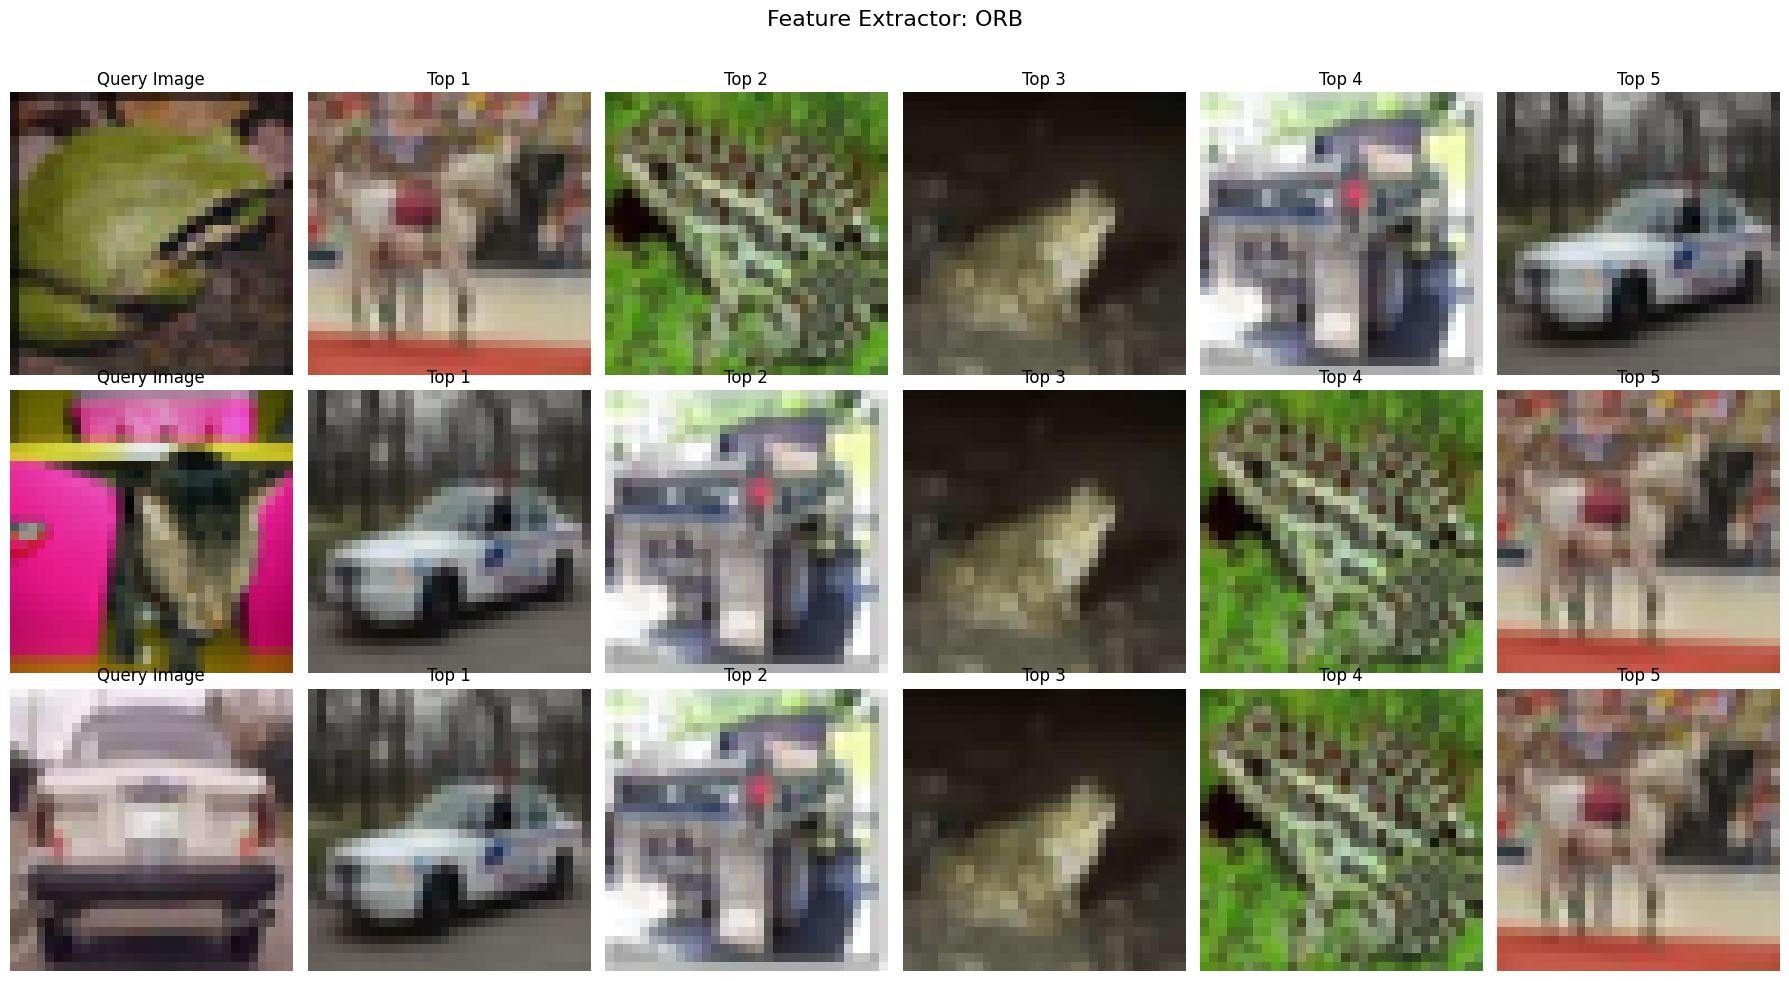


Feature extractor: ResNet
Querying with random image no: 972
Querying with random image no: 924
Querying with random image no: 272


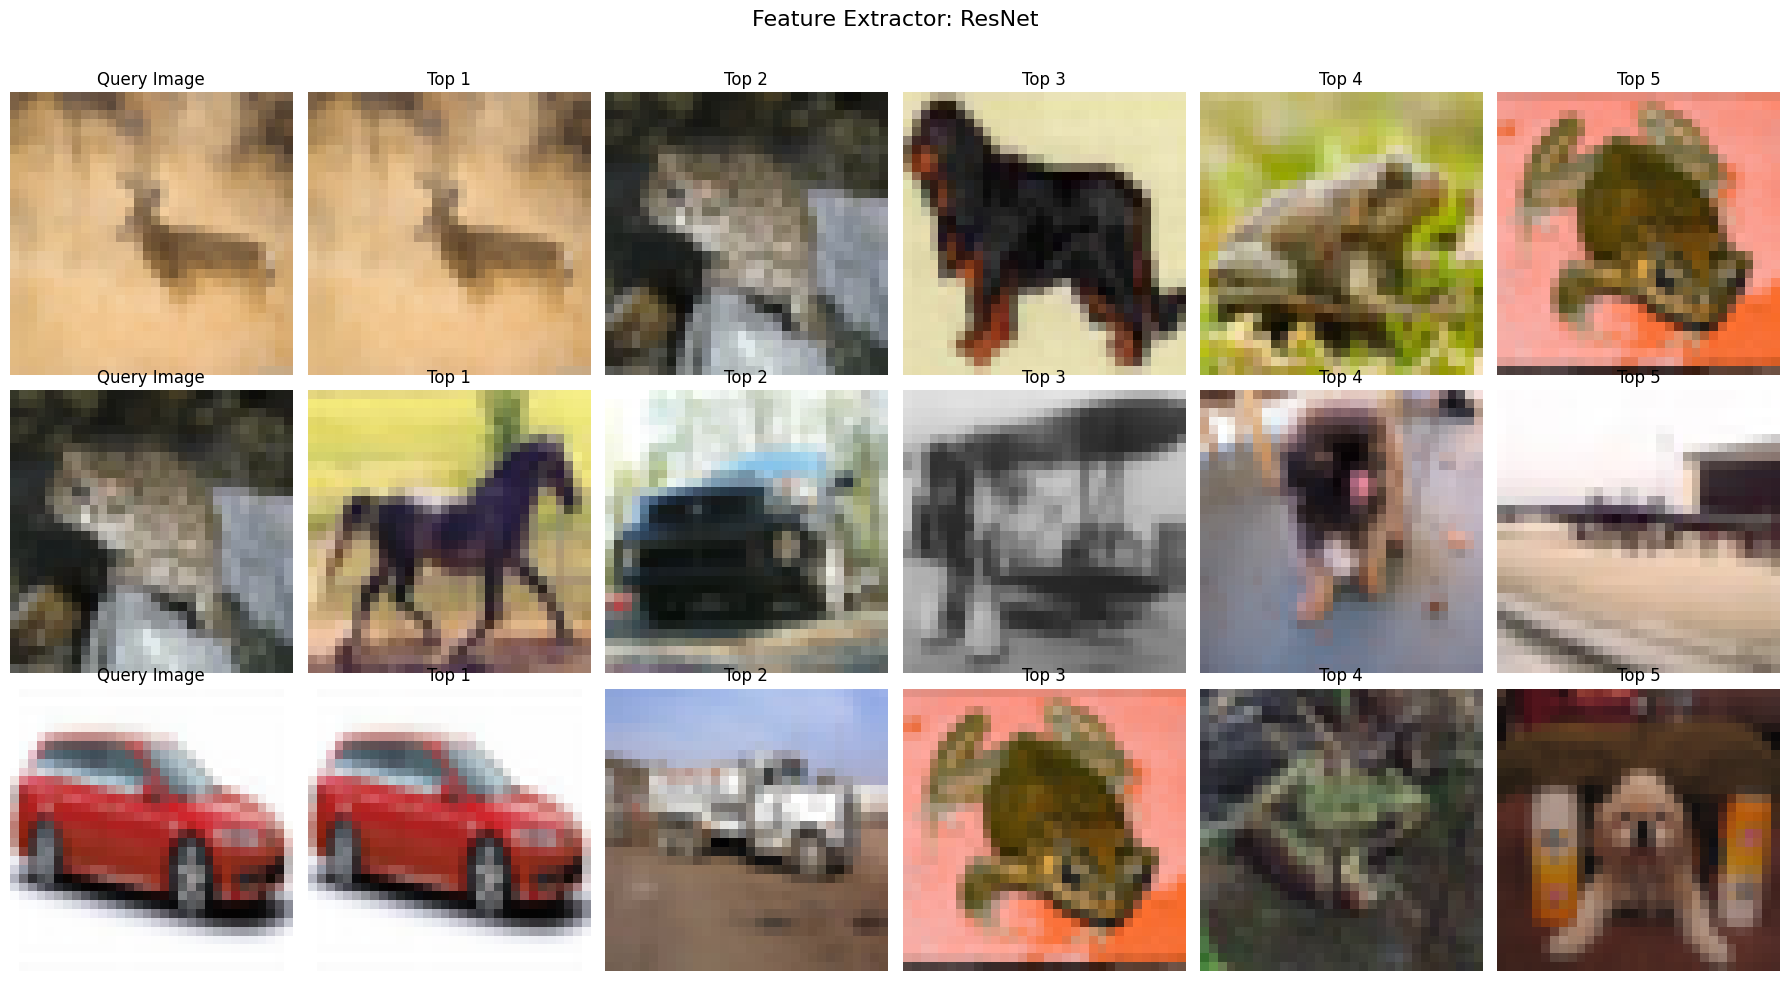


Feature extractor: DenseNet
Querying with random image no: 368
Querying with random image no: 932
Querying with random image no: 262


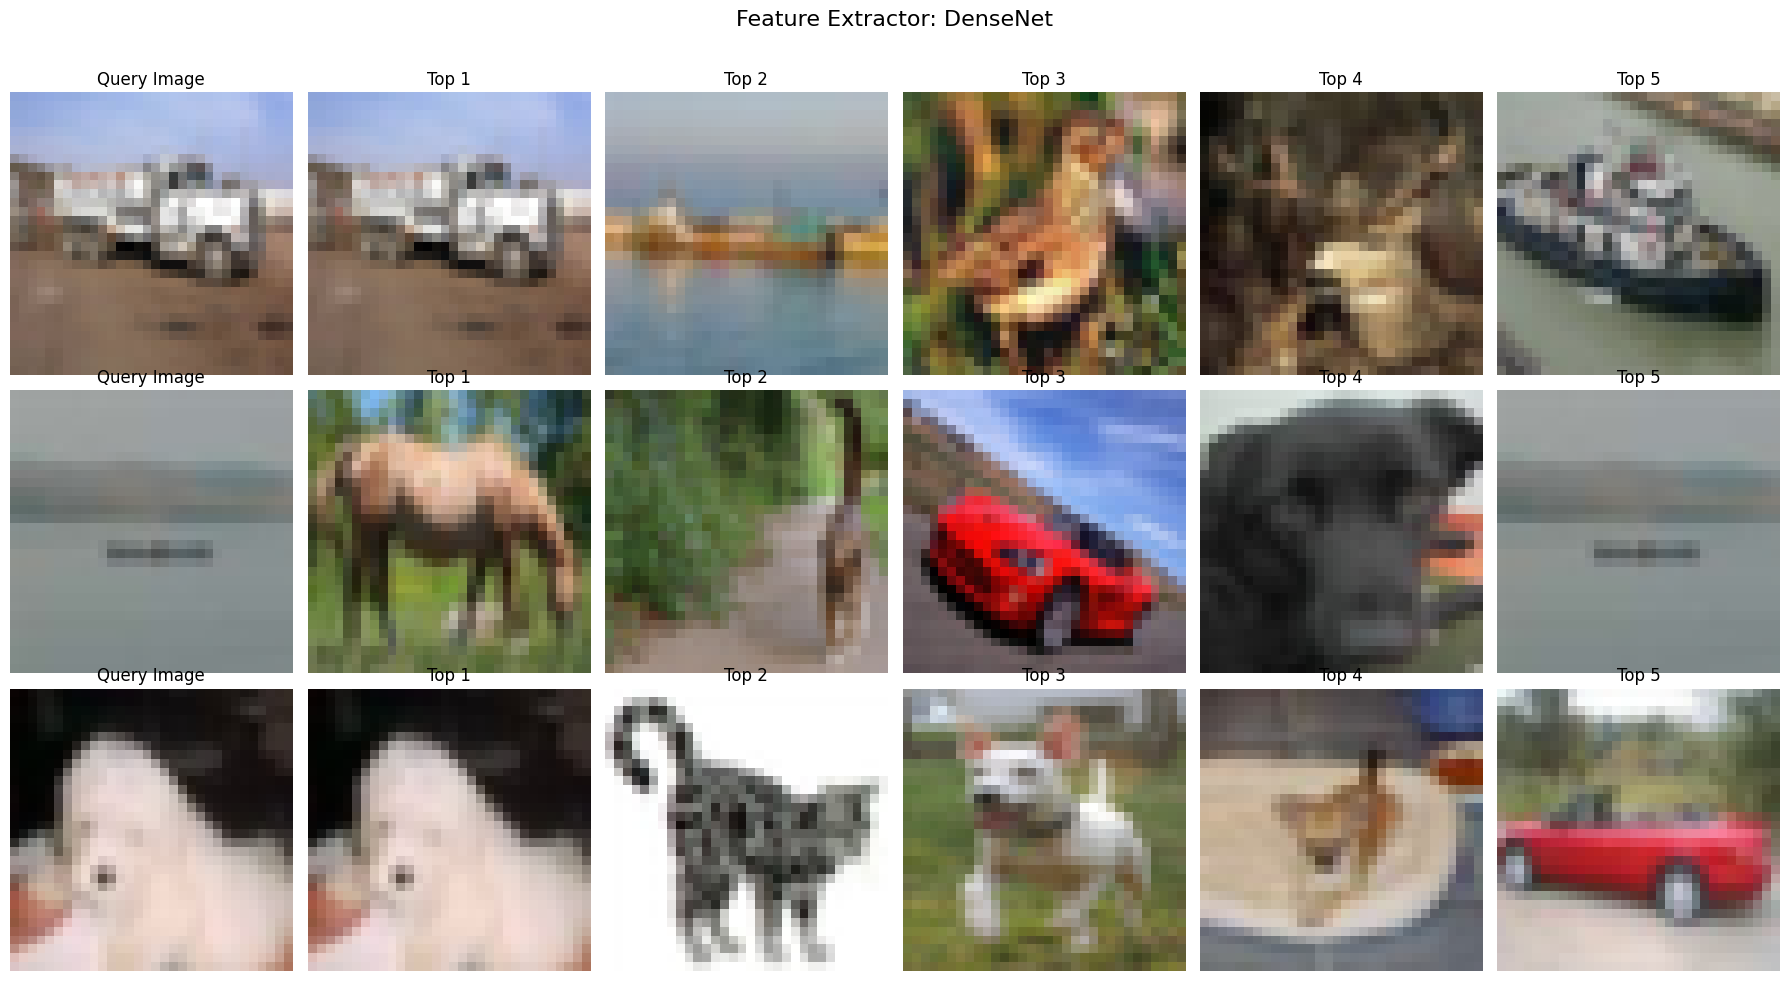

In [26]:
# Experiment with random query selection and display
def experiment_with_features(features, images, name, top_k=5):
    print(f"\nFeature extractor: {name}")
    
    # Set up a figure with 3 rows (for each metric: l2, inner_product, cosine)
    fig, axes = plt.subplots(3, top_k + 1, figsize=(18, 10))  # 3 rows, top_k + 1 columns (1 for query + 5 for similar images)
    fig.suptitle(f"Feature Extractor: {name}", fontsize=16)
    
    metrics = ["l2", "inner_product", "cosine"]
    
    # Loop through each metric and create one row for each metric
    for row, metric in enumerate(metrics):
          
        # Perform search using faiss
        distances, indices = faiss_search(features, metric=metric, top_k=top_k)
        
        # Pick a random query image from the dataset
        random_idx = random.randint(0, len(images) - 1)
        print(f"Querying with random image no: {random_idx}")
        
        # Display the query image in the first column (leftmost)
        axes[row, 0].imshow(np.transpose(images[random_idx].numpy(), (1, 2, 0)))  # Query image
        axes[row, 0].set_title("Query Image")
        axes[row, 0].axis('off')
        
        # Display the top 5 similar images for the current metric (in the remaining columns)
        for col in range(top_k):
            idx = indices[random_idx][col]  # Index of the similar image
            axes[row, col + 1].imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))  # Similar images
            axes[row, col + 1].set_title(f"Top {col + 1}")
            axes[row, col + 1].axis('off')
        
        # Add y-axis label for each metric
        axes[row, 0].set_ylabel(metric, fontsize=12, rotation=0, labelpad=40, color="black")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust title to fit
    plt.show()

# Run the experiment for each feature extractor
for features, name in [(sift_train_features, "SIFT"), (orb_train_features, "ORB"), (resnet_train_features, "ResNet"), (densenet_train_features, "DenseNet")]:
    experiment_with_features(features, test_images, name)
